# The *Complete* Guide to Ridge Regression
### Why We Penalize, Why We Scale, and How to Make It Work in Code

*“Regularization is like adding a shock‑absorber to your model; you still hit the bumps, but you don’t go flying off the track.”*

 > Ridge Regression (a.k.a. L2‑regularized linear regression) cures over‑fitting and multicollinearity by shrinking coefficients toward zero. But it only works its magic **after every feature is on the same numerical scale**. Below you’ll find the theory, intuition, pitfalls, and runnable Python demos.

## 1  Why Ordinary Least Squares Falls Apart

1. **Too many features, too little data** → the model memorises noise (high variance).
2. **Highly correlated predictors** → coefficients explode in opposite directions to compensate (unstable estimates).
3. **Heterogeneous feature ranges** (e.g. *age* 1‑100 vs. *income* 1‑1 000 000) → the optimisation landscape is stretched like ravioli, slowing or breaking convergence.

## 2  Ridge Regression in One Equation

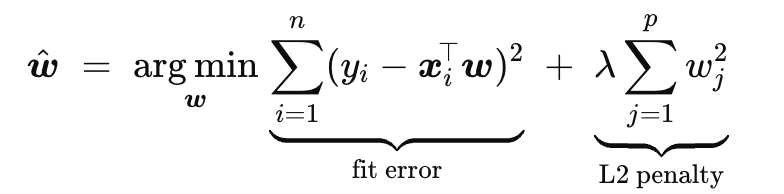

* **λ (lambda)** controls the trade‑off.  
  * λ = 0 → ordinary least squares.  
  * λ → ∞ → coefficients collapse toward zero (risk of under‑fitting).  
* The intercept is *not* penalised by default in `sklearn.linear_model.Ridge`.

## 3  Why Scaling Comes *Before* Ridge

| Reason | Without Scaling | Benefit of Scaling |
|---|---|---|
| **Fair λ** | Big‑range features get weak penalty; tiny‑range get huge penalty. | Equal regularisation pressure across dimensions. |
| **Numerical stability** | $X^{\top}X$ ill‑conditioned; small errors → huge coefficient swings. | Lower condition number ⇒ safer inversion & crisper gradients. |
| **Optimiser speed** | Gradients zig‑zag along skinny valleys. | Circular contours ⇒ faster, smoother convergence. |
| **Interpretability** | Weights incomparable. | Weight ≈ effect of **1 std‑dev** increase in that feature. |

> **Rule of thumb:** Always standardise (mean 0, std 1) before any model that penalises coefficient size (Ridge, Lasso, Elastic Net, etc.).

## 4  Ridge vs. Lasso

|          | **Ridge (L2)** | **Lasso (L1)** |
|---|---|---|
| Penalty | $\lambda\sum w_j^2$ | $\lambda\sum |w_j|$ |
| Effect | Shrinks, **keeps all features** | Shrinks and can **zero‑out** features |
| Best when | Many correlated predictors | True signal is sparse |
| Solver | Closed‑form / fast | Iterative optimisation |
| Coefficient path | Smooth | Piece‑wise linear & sparse |

## 5  Hands‑On #1 — Scaling vs. No Scaling
Run the next cell to see how coefficient magnitudes change when we scale the predictors before Ridge.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
np.random.seed(0)

# Synthetic data
n = 400
X_big   = np.random.uniform(500, 5000, size=(n, 1))      # large scale
X_small = np.random.uniform(1, 5, size=(n, 1))           # small scale
noise   = np.random.randn(n, 1) * 30
y = 0.05 * X_big + 10.0 * X_small + noise
X = np.hstack([X_big, X_small])

In [9]:
# Ridge without scaling
ridge_raw = Ridge(alpha=1.0).fit(X, y)
coefs_raw = ridge_raw.coef_.ravel()
print(coefs_raw)

[ 0.05062667 10.61346771]


In [10]:
# Ridge with scaling
pipe = Pipeline([('scale', StandardScaler()),
                 ('ridge', Ridge(alpha=1.0))])
pipe.fit(X, y)
coefs_scaled = pipe.named_steps['ridge'].coef_.ravel()

pd.DataFrame({'feature': ['big‑scale','small‑scale'],
              'no_scaling': coefs_raw,
              'with_scaling': coefs_scaled}).style.format(precision=3)

,feature,no_scaling,with_scaling
0,big‑scale,0.051,65.669
1,small‑scale,10.613,12.545


### Observation
Without scaling, the small‑range feature receives an **enormous** weight (and thus suffers a huge penalty). After scaling, both weights live on the same order of magnitude — Ridge works fairly.

## 6  Hands‑On #2 — Cross‑Validating λ the *Right* Way
We’ll tune λ on a log‑scale grid **inside** the scaling pipeline so the scaler never peeks at the validation folds.

In [11]:
from sklearn.model_selection import GridSearchCV, KFold

alphas = np.logspace(-3, 3, 25)  # 10^-3 ... 10^3
alphas

array([1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
       1.00000000e+03])

In [12]:
pipeline = Pipeline([('scale', StandardScaler()),
                     ('ridge', Ridge())])
param_grid = {'ridge__alpha': alphas}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv,
                    scoring='neg_root_mean_squared_error')
grid.fit(X, y.ravel())

best_alpha = grid.best_params_['ridge__alpha']
best_rmse  = -grid.best_score_

print(f"Best λ : {best_alpha:.4g}")
print(f"CV RMSE : {best_rmse:.3f}")


Best λ : 1.778
CV RMSE : 29.096


## 7  Summary Checklist

- [x] **Scale** every predictor before Ridge/Lasso/Elastic Net.  
- [x] Use a `Pipeline` so scaling occurs inside each CV fold.  
- [x] Tune λ with grid search or `RidgeCV`.  
- [x] Interpret coefficients only after scaling.  
- [x] Prefer Ridge when *all* features matter and multicollinearity is high.